In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

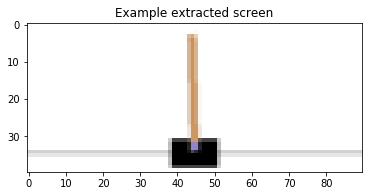

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [2]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

C:\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
env = gym.make('CartPole-v0')
for i_episode in range(10):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[-0.01718455 -0.04999386  0.04993704  0.04695384]
[-0.01818443  0.14437778  0.05087612 -0.22956478]
[-0.01529687  0.33873719  0.04628482 -0.50577554]
[-0.00852213  0.53317739  0.03616931 -0.7835206 ]
[ 0.00214142  0.33757754  0.0204989  -0.47968127]
[ 0.00889297  0.1421723   0.01090527 -0.18060873]
[ 0.01173641  0.33713651  0.0072931  -0.46983158]
[ 0.01847914  0.53215469 -0.00210353 -0.76020691]
[ 0.02912224  0.72730555 -0.01730767 -1.053551  ]
[ 0.04366835  0.92265265 -0.03837869 -1.35161596]
[ 0.0621214   0.72803315 -0.06541101 -1.07118224]
[ 0.07668206  0.92395609 -0.08683466 -1.3836553 ]
[ 0.09516119  0.73001797 -0.11450776 -1.1193415 ]
[ 0.10976155  0.53656903 -0.13689459 -0.86466016]
[ 0.12049293  0.73326225 -0.1541878  -1.19706118]
[ 0.13515817  0.93000635 -0.17812902 -1.53382806]
[ 0.1537583   0.73742106 -0.20880558 -1.30161448]
Episode finished after 17 timesteps
[ 0.0058662  -0.03391841 -0.01506446  0.02813312]
[ 0.00518783  0.1614163  -0.0145018  -0.26926449]
[ 0.00841616  

[ 4.09482344e-04 -7.49145917e-01 -5.51450190e-02  8.73077879e-01]
[-0.01457344 -0.9434764  -0.03768346  1.14792608]
[-0.03344296 -0.74788328 -0.01472494  0.84366837]
[-0.04840063 -0.5525635   0.00214843  0.54639149]
[-0.0594519  -0.74771557  0.01307626  0.83975056]
[-0.07440621 -0.9430136   0.02987127  1.13651686]
[-0.09326648 -1.13851329  0.05260161  1.43841643]
[-0.11603675 -1.33424251  0.08136993  1.74706192]
[-0.1427216  -1.53018953  0.11631117  2.06390632]
[-0.17332539 -1.3364293   0.1575893   1.80934813]
[-0.20005398 -1.53291874  0.19377626  2.1465698 ]
Episode finished after 25 timesteps
[ 0.04014321 -0.02326825  0.00241929 -0.019696  ]
[ 0.03967784 -0.21842481  0.00202537  0.27374926]
[ 0.03530935 -0.02333182  0.00750035 -0.01829417]
[ 0.03484271  0.17168177  0.00713447 -0.30860125]
[ 0.03827634  0.36670134  0.00096244 -0.59902564]
[ 0.04561037  0.17156594 -0.01101807 -0.30603971]
[ 0.04904169 -0.02339728 -0.01713886 -0.01685188]
[ 0.04857374  0.17196621 -0.0174759  -0.31489266